# 資料準備

In [1]:
import os
import pandas as pd

# 設定資料夾路徑
folder_path = '2330_financial'

# 取得資料夾中的所有檔案名稱
file_names = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# 使用 pandas 讀取所有 csv 檔案並儲存到列表中
dataframes = dict()
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    dataframes[file_name] = df


# 找到所有 csv 檔案的共同欄位
# common_columns = set(dataframes[0].columns)
# for df in dataframes[1:]:
#     common_columns = common_columns.intersection(set(df.columns))
common_columns = ['營業收入', '營業費用', '所得稅費用（利益）', '營業成本']




In [2]:
def assign_營業收入(date):
    year = date.year
    month = date.month
    if month <= 3:
        
        return dataframes[f"{year - 1911 - 1}.csv"].iloc[3]['營業收入']
    elif month <= 6:
        return dataframes[f"{year - 1911}.csv"].iloc[0]['營業收入']
    elif month <= 9:
        return dataframes[f"{year - 1911}.csv"].iloc[1]['營業收入']
    else:
        return dataframes[f"{year - 1911}.csv"].iloc[2]['營業收入']
        
def assign_營業費用(date):
    year = date.year
    month = date.month
    if month <= 3:
        
        return dataframes[f"{year - 1911 - 1}.csv"].iloc[3]['營業費用']
    elif month <= 6:
        return dataframes[f"{year - 1911}.csv"].iloc[0]['營業費用']
    elif month <= 9:
        return dataframes[f"{year - 1911}.csv"].iloc[1]['營業費用']
    else:
        return dataframes[f"{year - 1911}.csv"].iloc[2]['營業費用']
def assign_所得稅費用(date):
    year = date.year
    month = date.month
    if month <= 3:
        
        return dataframes[f"{year - 1911 - 1}.csv"].iloc[3]['所得稅費用（利益）']
    elif month <= 6:
        return dataframes[f"{year - 1911}.csv"].iloc[0]['所得稅費用（利益）']
    elif month <= 9:
        return dataframes[f"{year - 1911}.csv"].iloc[1]['所得稅費用（利益）']
    else:
        return dataframes[f"{year - 1911}.csv"].iloc[2]['所得稅費用（利益）']

def assign_營業成本(date):
    year = date.year
    month = date.month
    if month <= 3:
        
        return dataframes[f"{year - 1911 - 1}.csv"].iloc[3]['營業成本']
    elif month <= 6:
        return dataframes[f"{year - 1911}.csv"].iloc[0]['營業成本']
    elif month <= 9:
        return dataframes[f"{year - 1911}.csv"].iloc[1]['營業成本']
    else:
        return dataframes[f"{year - 1911}.csv"].iloc[2]['營業成本']

In [3]:


filename = "2330.csv"

df = pd.read_csv(filename, index_col=False)
convert_cols = ["成交股數",	"成交金額",	"開盤價", "最高價",	"最低價", "收盤價", "漲跌價差", "成交筆數"]
df["漲跌價差"] = df["漲跌價差"].replace("X", '', regex=True)
df[convert_cols] = df[convert_cols].replace(',', '', regex=True).astype(float)
df["日期"] = df["日期"].apply(lambda x: f"{int(x.split('/')[0]) + 1911}/{x.split('/')[1]}/{x.split('/')[2]}")
df["日期"] = pd.to_datetime(df["日期"], format="%Y/%m/%d")

df['營業收入'] = df['日期'].apply(assign_營業收入)
df['營業費用'] = df['日期'].apply(assign_營業費用)
df['所得稅費用（利益）'] = df['日期'].apply(assign_所得稅費用)
df['營業成本'] = df['日期'].apply(assign_營業成本)

using_cols = ["開盤價", "最高價", "最低價", "收盤價", "漲跌價差", '營業收入', '營業費用', '所得稅費用（利益）', '營業成本']

data = df[using_cols]


In [4]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler



# 數據預處理：將股價標準化
def preprocess_data(data, time_step=60):
    # 使用 MinMaxScaler 來標準化所有特徵
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data.values)  # 標準化所有特徵（Open, High, Low, Close, Volume）
    
    X, y = [], []
    for i in range(time_step, len(data_scaled)):
        X.append(data_scaled[i-time_step:i, :])  # 包含所有特徵
        y.append(data_scaled[i, 3])  # y 是收盤價（'Close' 列），其索引為3
    
    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # LSTM 需要的形狀 (samples, time_steps, features)
    
    print(X.shape)
    print(y.shape)

    return X, y, scaler


# 訓練與預測函數

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定義LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=9, hidden_layer_size=64, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, x):
        # LSTM 返回的 output 是一個包含隱藏層和細胞狀態的元組
        out, (hn, cn) = self.lstm(x)
        # 只取序列的最後一個時間步的輸出
        out = self.fc(out[:, -1, :])
        return out

def train_model(X_train, y_train, model=None, epochs=100, batch_size=32, model_save_path="best_model.pth"):
    model = model
    criterion = nn.SmoothL1Loss()  # 均方誤差損失
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    best_loss = float('inf')  # 用來追踪最小損失
    best_model_wts = None  # 用來儲存最佳模型的權重

    epoch_losses = []  # 用來記錄每個 epoch 的損失
    epoch_mse = []  # 用來記錄每個 epoch 的 MSE
    epoch_rmse = []  # 用來記錄每個 epoch 的 RMSE

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train.view(-1, 1))  # Reshape y_train 為列向量
        loss.backward()
        optimizer.step()

        # 記錄每個 epoch 的損失和指標
        epoch_losses, epoch_mse, epoch_rmse = record_training_loss_and_metrics(
            epoch_losses, epoch_mse, epoch_rmse, y_train.view(-1, 1).detach().numpy(), output.detach().numpy(), loss.item()
        )

        # 更新最佳模型
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model_wts = model.state_dict()  # 儲存最佳模型的權重

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, MSE: {epoch_mse[-1]:.4f}, RMSE: {epoch_rmse[-1]:.4f}")
    
    # 保存最佳模型
    torch.save(best_model_wts, model_save_path)
    print(f"Best model saved at epoch {epochs} with loss {best_loss:.4f}")
    
    return model, epoch_losses, epoch_mse, epoch_rmse

# 4. 預測股價
def load_model(model=None, model_save_path="best_model.pth"):
    model = model
    model.load_state_dict(torch.load(model_save_path))  # 載入保存的模型權重
    model.eval()  # 設定模型為評估模式
    return model

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch

# 4. 預測股價並計算指標
def predict_stock_price(model, X_test, scaler, y_test, num_steps=60, col=2):
    # 只取前 num_steps 個時間步的測試數據
    X_test = X_test[:num_steps]
    y_test = y_test[:num_steps]
    print(y_test.shape)
    with torch.no_grad():
        predicted_stock_price = model(X_test)  # 使用模型進行預測
    
    # 假設 predicted_stock_price 是形狀為 (60, 1) 的數據
    
    
    # 反標準化預測結果和真實股價
    min_value = scaler.data_min_[3]  # 提取對應列的最小值
    max_value = scaler.data_max_[3]  # 提取對應列的最大值
    range_value = max_value - min_value
    
    predicted_stock_price = predicted_stock_price * range_value + min_value
    real_stock_price = y_test * range_value + min_value

    # 計算指標
    mse = mean_squared_error(real_stock_price, predicted_stock_price)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real_stock_price, predicted_stock_price)

    # 顯示指標
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    
    return predicted_stock_price, real_stock_price



# 可視化

In [6]:


from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 可視化結果，加入時間索引
def visualize_results(real_stock_price, predicted_stock_price, ticker, start_idx=0, end_idx=None, time_index=None, col=2):
    # 如果未指定結束索引，則顯示整個時間段
    if end_idx is None:
        end_idx = len(real_stock_price)

    # 只選取指定區間的資料
    real_stock_price = real_stock_price[start_idx:end_idx]
    predicted_stock_price = predicted_stock_price[start_idx:end_idx]

    # 如果提供了時間索引，使用時間索引作為x軸
    if time_index is not None:
        time_index = time_index[start_idx:end_idx]  # 根據開始和結束索引切分時間
        plt.plot(time_index, real_stock_price, color='blue', label='Real Stock Price')
        plt.plot(time_index, predicted_stock_price, color='red', label='Predicted Stock Price')
        plt.xlabel('Time')
    else:
        plt.plot(real_stock_price, color='blue', label='Real Stock Price')
        plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')

    plt.title(f'{ticker} Stock Price Prediction')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.xticks(rotation=45)  # 適當旋轉時間軸標籤，避免重疊
    plt.show()

# 訓練過程資料記錄和可視化
def record_training_loss_and_metrics(epoch_losses, epoch_mse, epoch_rmse, y_true, y_pred, loss_value):
    """
    記錄訓練過程中的每個epoch的損失和指標（MSE, RMSE）
    """
    epoch_losses.append(loss_value)
    
    # 計算 MSE 和 RMSE
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    epoch_mse.append(mse)
    epoch_rmse.append(rmse)
    
    return epoch_losses, epoch_mse, epoch_rmse


def visualize_training_metrics(epoch_losses, epoch_mse, epoch_rmse, epochs):
    """
    繪製訓練過程中的損失、MSE、RMSE曲線
    """
    plt.figure(figsize=(14, 6))
    
    # 損失曲線
    plt.subplot(1, 3, 1)
    plt.plot(range(epochs), epoch_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    
    # MSE曲線
    plt.subplot(1, 3, 2)
    plt.plot(range(epochs), epoch_mse, label='MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Training MSE Over Epochs')
    plt.legend()
    
    # RMSE曲線
    plt.subplot(1, 3, 3)
    plt.plot(range(epochs), epoch_rmse, label='RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Training RMSE Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


# 模型訓練

In [7]:
ticker = '2330.TW'
start_date = '2010-01-01'
end_date = '2023-01-01'
time_step = 60

from sklearn.model_selection import train_test_split

# 1. 數據準備
data = df[using_cols]
X, y, scaler = preprocess_data(data, time_step)

# 2. 隨機分割數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 轉換為 PyTorch tensor
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


(3178, 60, 9)
(3178,)


In [8]:
# 3. 訓練模型並保存最佳模型
model = LSTMModel(input_size=9, hidden_layer_size=50, output_size=1)
model_save_path = "best_model.pth"
model, epoch_losses, epoch_mse, epoch_rmse = train_model(X_train, y_train, model=model, epochs=100)

Epoch [5/100], Loss: 0.0451, MSE: 0.0903, RMSE: 0.3005
Epoch [10/100], Loss: 0.0221, MSE: 0.0442, RMSE: 0.2103
Epoch [15/100], Loss: 0.0108, MSE: 0.0216, RMSE: 0.1469
Epoch [20/100], Loss: 0.0120, MSE: 0.0240, RMSE: 0.1549
Epoch [25/100], Loss: 0.0097, MSE: 0.0194, RMSE: 0.1393
Epoch [30/100], Loss: 0.0067, MSE: 0.0134, RMSE: 0.1160
Epoch [35/100], Loss: 0.0058, MSE: 0.0115, RMSE: 0.1073
Epoch [40/100], Loss: 0.0044, MSE: 0.0088, RMSE: 0.0938
Epoch [45/100], Loss: 0.0029, MSE: 0.0059, RMSE: 0.0768
Epoch [50/100], Loss: 0.0024, MSE: 0.0049, RMSE: 0.0697
Epoch [55/100], Loss: 0.0016, MSE: 0.0033, RMSE: 0.0570
Epoch [60/100], Loss: 0.0013, MSE: 0.0026, RMSE: 0.0510
Epoch [65/100], Loss: 0.0009, MSE: 0.0018, RMSE: 0.0423
Epoch [70/100], Loss: 0.0007, MSE: 0.0013, RMSE: 0.0367
Epoch [75/100], Loss: 0.0005, MSE: 0.0009, RMSE: 0.0307
Epoch [80/100], Loss: 0.0003, MSE: 0.0007, RMSE: 0.0259
Epoch [85/100], Loss: 0.0003, MSE: 0.0006, RMSE: 0.0239
Epoch [90/100], Loss: 0.0003, MSE: 0.0005, RMSE: 

torch.Size([60])
Mean Squared Error (MSE): 327.6753
Root Mean Squared Error (RMSE): 18.1018
Mean Absolute Error (MAE): 16.1419


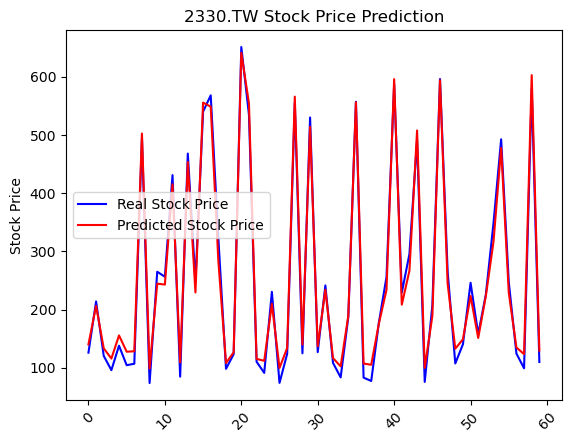

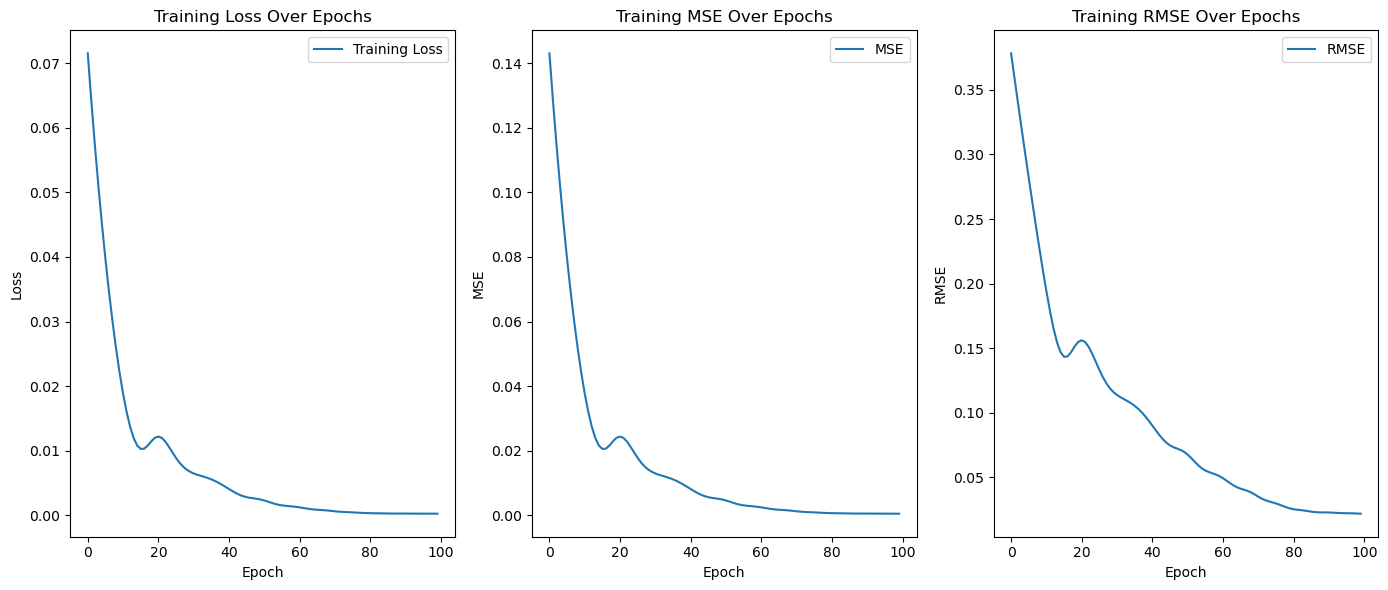

In [17]:
# 4. 載入最佳模型
best_model = load_model(model=model, model_save_path=model_save_path)

# 5. 預測股價並顯示指標
predicted_stock_price, real_stock_price = predict_stock_price(best_model, X_test, scaler, y_test, 60)

# 6. 可視化結果，顯示時間軸
visualize_results(real_stock_price, predicted_stock_price, ticker, 0, 600)

# 7. 訓練過程可視化
visualize_training_metrics(epoch_losses, epoch_mse, epoch_rmse, 100)